# NLP & W2VEC

In [2]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from pythainlp.tokenize import THAI2FIT_TOKENIZER, word_tokenize # ใช้ในการตัดคำ
from pythainlp.corpus import common # ใช้ลบคำที่ไม่ใช้ออก

from sklearn import preprocessing

# Word2Vec
from pythainlp.word_vector import WordVector
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# AI
from sklearn.model_selection import train_test_split # split data set
from sklearn.metrics import accuracy_score, classification_report # report train & test result

# AI Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Hyperparameter Tunning
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.plots import plot_objective, plot_histogram

# Saving Intelligence
from joblib import dump, load


In [3]:
data = pd.read_csv("./data/message_temp.csv")
data = data[['message', 'category']]

In [4]:
data.head()

,message,category
0,ขอบคุณค่ะ,C
1,โอเคค่ะ,C
2,ให้อาจารย์เซ็นเรียบร้อยแล้วครับ,T
3,ได้ค่ะ,C
4,โอเคครับ ผมขอเอาไปให้อาจารย์เซ็นก่อนครับ,T


### Data Features and Values

In [5]:
data['category'].unique()

array(['C', 'T', 'Q', 'S', 'A'], dtype=object)

In [6]:
# filter common chat
data = data.drop(data.index[ data['category'] == 'C' ])
# sort data by category
data = data.sort_values(by=['category'])

data = data.reset_index()
data = data[['message', 'category']]

data.head()

,message,category
0,ตรวจการบ้านไปประมาณ 2 ชิ้นครับ,A
1,ตรงงานที่ทำ,A
2,กรอกคำว่า ตรวจการบ้าน อย่างเดี่ยวเลยค่ะ,A
3,หนังสือรับรองเข้าฝึกงานจากบริษัทครับ,A
4,ครั้งที่แล้วยังไม่ส่งเอกสารเบิกจ่ายหรือค่ะ,A


In [7]:
data.shape

(73, 2)

In [6]:
data.dtypes

message     object
category    object
dtype: object

In [7]:
data.isnull().any()

message     False
category    False
dtype: bool

### Countplot of target Variable(Category)

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='category', ylabel='count'>

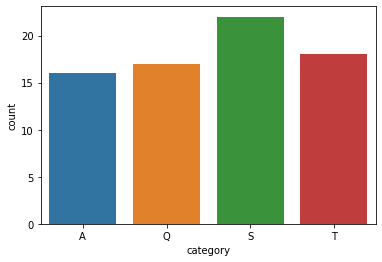

In [8]:
sns.countplot(data.category)

In [10]:
data['message_length'] = data['message'].str.len()
print(data['message_length'])

0      30
1      11
2      39
3      36
4      42
     ... 
68     23
69     27
70     40
71     39
72    123
Name: message_length, Length: 73, dtype: int64


### Words Distribution Plot

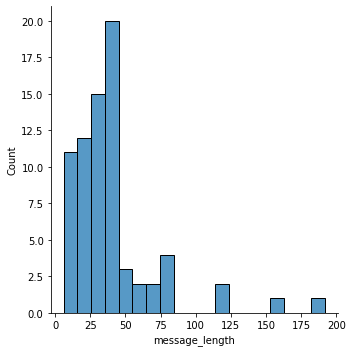

In [11]:
sns.displot(data['message_length']).set_titles('message_length')

### Count Words

In [20]:
def count_words(category=''):
    word_list = set()
    if(category != ''):
        sub_frame = data[data['category']==category]
    else:
        sub_frame = data

    for text in sub_frame['message']:
        
        text = text.lower().replace('\n', ' ').replace('\r', '').strip()
        text = re.findall(r"[\u0E00-\u0E7Fa-zA-Z']+", text)
        text = ' '.join(text)

        word_tokens = THAI2FIT_TOKENIZER.word_tokenize(text)
        filtered_sentence = set([w for w in word_tokens])

        word_list.update(filtered_sentence)

    return len(word_list)

In [21]:
print('T: ')
print(count_words('T'))
print('S: ') 
print(count_words('S'))
print('A: ') 
print(count_words('A'))
print('Q: ') 
print(count_words('Q'))

print('Total:')
print(count_words())


T: 
103
S: 
109
A: 
72
Q: 
116
Total:
275


### Word Cloud

In [11]:
def create_wordcloud(words):
    wordcloud = WordCloud(font_path='THSarabun.ttf', # path ที่ตั้ง Font
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(THAI2FIT_TOKENIZER.word_tokenize(words)))
    plt.figure(figsize=[10, 7])
    plt.imshow(wordcloud, interpolation= "bilinear")
    plt.axis('off')
    plt.show()

In [12]:
def check_wordcloud(category):
    subset = data[data.category==category]
    text = subset.message.values
    words = ''.join(text)
    create_wordcloud(words)

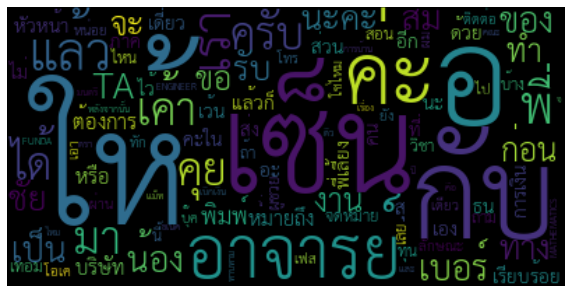

In [13]:
check_wordcloud('T')

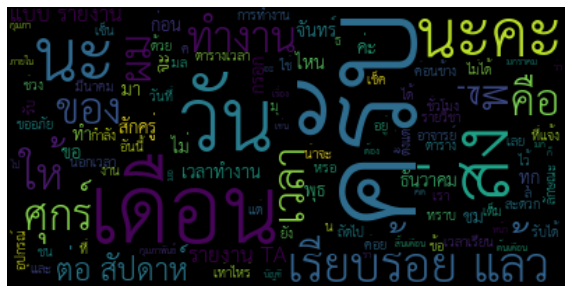

In [14]:
check_wordcloud('S')

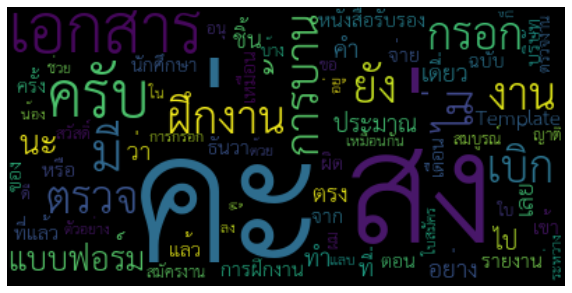

In [15]:
check_wordcloud('A')

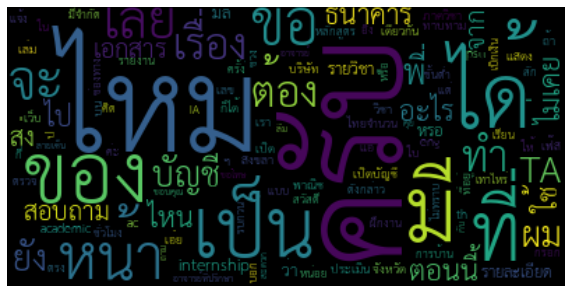

In [16]:
check_wordcloud('Q')

### Label Encoding

In [17]:
label_encoder = preprocessing.LabelEncoder()
data['category_target'] = label_encoder.fit_transform(data['category'])

In [18]:
temp_data = data[['category', 'category_target']].drop_duplicates()
print(temp_data)

   category  category_target
0         A                0
16        Q                1
33        S                2
55        T                3


In [19]:
# keep category target in json
json_classes = temp_data.to_json(orient="records")

# Writing to .json
with open("classes.json", "w") as outfile:
    outfile.write(json_classes)


   


In [20]:
# Opening JSON file
with open('classes.json', 'r') as openfile:
    # Reading from json file
    temp_json = json.load(openfile)
    print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'Q', 'category_target': 1}, {'category': 'S', 'category_target': 2}, {'category': 'T', 'category_target': 3}]


In [21]:
temp_json.sort(key=lambda item : item['category_target'])
print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'Q', 'category_target': 1}, {'category': 'S', 'category_target': 2}, {'category': 'T', 'category_target': 3}]


In [22]:
classes_list = [ item['category'] for item in temp_json]
print(classes_list)

['A', 'Q', 'S', 'T']


### Word2Vec

In [25]:
w2v_thai = WordVector()

In [26]:

word2vec = [w2v_thai.sentence_vectorizer(data['message'][i]) 
            for i in range(0,len(data['message']))]

In [27]:
X = np.array(word2vec).tolist()

data['word2vec'] = X
data_reshape = np.reshape(X, (-1, 300))

In [28]:
print(data_reshape.shape)

(73, 300)


In [29]:
data.head()

,message,category,message_length,category_target,word2vec
0,ตรวจการบ้านไปประมาณ 2 ชิ้นครับ,A,30,0,"[[-0.04368922238548597, -0.1073357808507151, 0..."
1,ตรงงานที่ทำ,A,11,0,"[[0.18430849723517895, -0.26013100426644087, 0..."
2,กรอกคำว่า ตรวจการบ้าน อย่างเดี่ยวเลยค่ะ,A,39,0,"[[-0.016739728013900192, -0.10112627263350243,..."
3,หนังสือรับรองเข้าฝึกงานจากบริษัทครับ,A,36,0,"[[0.07958716742966014, -0.09782449932148059, 0..."
4,ครั้งที่แล้วยังไม่ส่งเอกสารเบิกจ่ายหรือค่ะ,A,42,0,"[[-0.10494039803743363, -0.0019164031371474266..."


# AI MODEL

### Split the data in Training and Testing

In [30]:
data_temp = [ x for x in data['word2vec']]
data_reshape = np.reshape(data_temp, (-1, 300))
data_reshape.shape


(73, 300)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data_reshape,
                                                    data['category_target'],
                                                    test_size = 0.2,
                                                    )

In [39]:
print(X_train.shape)
print(y_train.shape)

(58, 300)
(58,)


In [40]:
print(X_test.shape)
print(y_test.shape)

(15, 300)
(15,)


### Models Predictions

In [48]:
# LinerRegression Model
l_model = LogisticRegression()
l_model.fit(X_train, y_train)
model_predictions = l_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.67      0.50      0.57         4
           2       0.50      1.00      0.67         4
           3       1.00      0.67      0.80         3

    accuracy                           0.67        15
   macro avg       0.79      0.67      0.68        15
weighted avg       0.78      0.67      0.67        15



In [85]:
# Unsupervised Model
kn_model = KNeighborsClassifier(p=4, n_neighbors=2)
kn_model.fit(X_train, y_train)
model_predictions = kn_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.6
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      1.00      0.67         4
           2       0.67      0.50      0.57         4
           3       0.00      0.00      0.00         3

    accuracy                           0.60        15
   macro avg       0.48      0.56      0.50        15
weighted avg       0.51      0.60      0.53        15



c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [91]:
# RandomForest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
model_predictions = rf_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.4666666666666667
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.40      0.50      0.44         4
           2       0.50      0.75      0.60         4
           3       0.50      0.33      0.40         3

    accuracy                           0.47        15
   macro avg       0.47      0.46      0.44        15
weighted avg       0.47      0.47      0.45        15



In [60]:
# GaussianNB Model
g_model = GaussianNB()
g_model.fit(X_train, y_train)
model_predictions = g_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.6
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.25      0.33         4
           2       0.50      0.75      0.60         4
           3       0.67      0.67      0.67         3

    accuracy                           0.60        15
   macro avg       0.60      0.60      0.59        15
weighted avg       0.60      0.60      0.58        15



### Save AI Model

In [64]:
dump(l_model, './models/l_model.joblib')

['./models/l_model.joblib']

In [65]:
dump(kn_model, './models/kn_model.joblib')

['./models/kn_model.joblib']

In [66]:
dump(rf_model, './models/rf_model.joblib')

['./models/rf_model.joblib']

In [67]:
dump(g_model, './models/g_model.joblib')

['./models/g_model.joblib']

### BayesSearch Hyperparameter Tunning

In [69]:
model = KNeighborsClassifier()
opt = BayesSearchCV(
    model,
    {
        'n_neighbors': Integer(1, 20),
        'p': Integer(1, 20)
    }
    , cv=3, verbose=1, n_jobs=1
)
opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
0.5368421052631579
OrderedDict([('n_neighbors', 3), ('p', 4)])


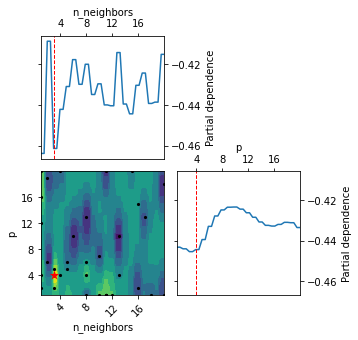

In [70]:
plot_objective(opt.optimizer_results_[0],
                   dimensions=['n_neighbors','p'],
                   n_minimum_search=int(1e8))
plt.show()

# Use Case

In [94]:
# load w2vector model and ai model
model = load('./models/g_model.joblib') 
w2v_thai = WordVector()

In [95]:
text_input = 'พรุ่งนี้มีนัดทำงานนะ'

In [96]:

test_vec = w2v_thai.sentence_vectorizer(text_input)
test_vec.shape

(1, 300)

In [98]:
output = model.predict(test_vec)
output_classes = label_encoder.classes_
output_label = output_classes[output[0]]
output_label

'A'

# Use Case with Modules


In [2]:
from project_module.message_classifier import MessageClassifier
message_classifier = MessageClassifier()

In [3]:
message_classifier.load_model(model_path='./models/l_model.joblib', json_classes_path='./classes.json')

In [8]:
print(message_classifier.classify(text_input='วันนี้ทำงานอะไร'))

S
